### Ethan Maluhia Roberts - Smarsh Technical
### Summary
#### Intro
The goal of this assessment is to clean and prepare IMDB reviews for classification through machine learning techniques and models, and then evaluate the models using common metrics. The data set comes from [Stanford, through Hugging Face](https://huggingface.co/datasets/stanfordnlp/imdb). It is split evenly between positive and negative reviews, 25k samples for each, with 50k unsupervised samples to classify after training and testing.

#### EDA
My assumptions are that the data is independent and identically distributed, randomly sampled, the labels represent the overall sentiment of the reviews, and there does exist a boundary between the positive and negative reviews.

I did basic data checks to make sure what I was given was clean and usable, and I just had to clean up newline characters in the text. I also broke down the review lengths and checked for high occurence words.

#### Methods
I used the following supervised machine learning models for classification:
* Support Vector Machines because of their ability to handle high dimensional data and their ability to use different kernels.
* Naive Bayes again for their ability to work in high dimensional data, its ability to predict the probability of Positive/Negative sentiment based on multiple word counts, and its scalability, working quickly with large datasets.
* Logistic Regression because of it ability to be regularized easily, its ability to work well with sparse matrices, and its scalability, again working quickly with this dataset.
* Convolutional Neural Network since it is a more trainable model that, among Neural Networks, performs better with high dimensionality and learns the features quickly.

#### Analysis
I used Gridsearch to find the best parameters for the SVM, but it takes several hours and gets about an 87% accuracy. The un-GridSearched SVM takes about 15 minutes and gets similar results. Naive Bayes is almost instant and gets 83% accuracy. I used ElasticNet on Logistic Regression and the best result set the L1 parameter to 0, so all regulization is L2, or Ridge Regression, shrinking coefficients instead of variable selection. Logistic Regression took about a second to run and yielded the most accurate results of my tests, 88%. Finally, I ran a Keras Tuner on a Convolutional Neural Network that took about 20 seconds and gave back about 83% accuracy.

#### Conclusion
Using basic metrics such as precision, recall, f1-score, accuracy, and runtime, I recommend using the Logistic Regression outlined in the code for classification.

#### Next Steps
With unlimited time and money, I would try stacking the models, taking the Logistic Regression's misclassifications and running them through one of my other models to make a better classifying machine. I understand Smarsh's Intelligent Agent acts the same way, reviewing computationaly cheaper models' mistakes as a more expensive model to correct them.

I would like to try classification forests as well, but training the forest can take time. Other models to try include mixture models such as Gaussian Mixture Model (GMM) and boosting methods such as XGBoost.

I would also try "tuning" Naive Bayes specifically with something like N-grams or GloVe to determine word co-occurences and get over the naive limitations.

I would revisit my EDA analysis that goes into more depth below, looking at the distribution of text length and words used to see if either could improve the classification.

I would also get some better tech to run these models faster. I switched computers halfway through the analysis to higher RAM and it didn't improve the runtime like I expected, so maybe a better GPU.

### Getting Started
#### EDA
I always import pandas and numpy as defaults. For timing the models, I brought in the time library as well.

In [1]:
# Basics
import pandas as pd
import numpy as np
import time

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data Prep
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Methods
from sklearn.model_selection import GridSearchCV # SVM
from sklearn.svm import SVC # SVM
from sklearn.naive_bayes import MultinomialNB # NB
from sklearn.linear_model import LogisticRegression # LR

# CNN
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Import the data
from datasets import load_dataset
data = load_dataset("stanfordnlp/imdb")

I checked to see what kind of data I was working with to see if I needed to get it into a pandas dataframe or if that was the default.

In [2]:
display(data)

# DatasetDict to dataframes
train_data = pd.DataFrame(data['train'])
test_data = pd.DataFrame(data['test'])
unsupervised_data = pd.DataFrame(data['unsupervised'])

print("\nTraining Data:")
display(train_data.head(5))

print("\nTesting Data:")
display(test_data.head(5))

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


Training Data:


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0



Testing Data:


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


I'm in a unique situation, where the distribution of data is already given to me. That said, I like to double check my data just to be sure there are no surprises, so I checked the distribution of positive/negative labels, just to confirm.

In [3]:
print(train_data['label'].value_counts())

label
0    12500
1    12500
Name: count, dtype: int64


The instructions and intro document was correct, the data is distributed evenly. If the data was uneven, I would consider using the SMOTE algorithm to balance out the data.

I also want to check null values and make sure nothing is missing or any rows need to be dropped.

In [4]:
print(train_data.isnull().sum())

text     0
label    0
dtype: int64


No nulls is good nulls.

For my own EDA and analysis down the road, I'd like to see the data, specifically the length of the data and the most used words in the reviews. Later, when classifying, we can start making connections and seeing if reviews under 500 characters are more likely to be negative or positive, can some high-use words be used to predict a positive or negative review like you would do for a spam email containing "free" or "$$$", etc.

In [5]:
# Get lengths of each review for a histogram
train_data['length'] = train_data['text'].apply(len)
print(train_data['length'].describe())

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: length, dtype: float64


C:\Users\mroberts\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


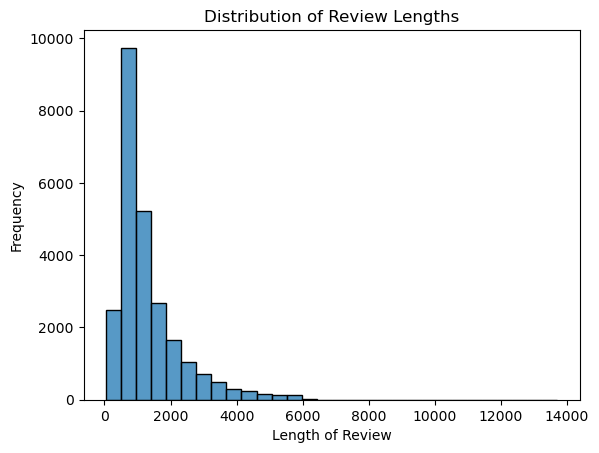

In [6]:
# Plot histogram
sns.histplot(train_data['length'], bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

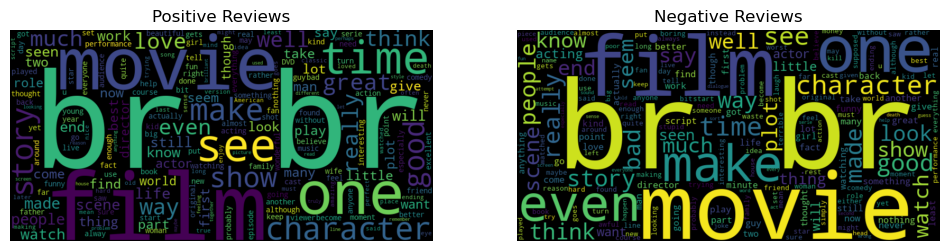

In [7]:
# Word Clouds

# Split reviews
positive_reviews = ' '.join(train_data[train_data['label'] == 1]['text'])
negative_reviews = ' '.join(train_data[train_data['label'] == 0]['text'])

# Create the clouds
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

# Plot both
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

I utilized the wordclouds because they give easy visualizations to see the high frequency words. This brought this "br" to my attention. My first thought was they were most likely a newline break tag.

In [8]:
# Remove truncation to see the whole entry, only first entry needed here for space
pd.set_option('display.max_colwidth', None) # https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver
display(train_data.head(1))

,text,label,length
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",0,1640


This sample validated my assumption that "br" is the newline tag, so I removed them from training and testing data since they are not part of the reviews.

In [9]:
# Replace the <br /> tags in train and test data
train_data['text'] = train_data['text'].apply(lambda x: x.replace("<br />"," "))
test_data['text'] = test_data['text'].apply(lambda x: x.replace("<br />"," "))
display(train_data.head(1))
pd.set_option('display.max_colwidth', 50) # put back the truncation

,text,label,length
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. While my countrymen mind find it shocking, in reality sex and nudity are a major staple in Swedish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films. I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",0,1640


Once I confirmed the \<br /> tags were removed, I reran the wordcloud.

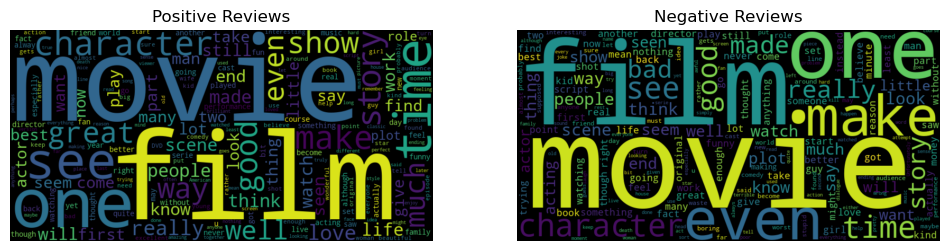

In [10]:
positive_reviews = ' '.join(train_data[train_data['label'] == 1]['text'])
negative_reviews = ' '.join(train_data[train_data['label'] == 0]['text'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

Now that it looked good with no strange words in the clouds, I was able to get started.

#### Methods
I set up my 'text' columns as TF-IDF vectors and set up my training and testing data to be used throughout the different models. I also removed the regular stopwords to help with my storage size.

In [11]:
vectorized = TfidfVectorizer(stop_words = 'english', lowercase = True) # https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# training data
X_train = vectorized.fit_transform(train_data['text'])
y_train = train_data['label']

# testing data
X_test = vectorized.transform(test_data['text'])
y_test = test_data['label']

I started with a basic Support Vector model, using GridSearch to find the best parameters. The GridSearch results took several hours to compute, where the base SVM took about 15 minutes and had comparable results. I do not recommend this method for computationally restricted situations.

In [12]:
svm_start = time.time()
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy') # https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

# Fit it to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and estimator
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_
svm_y_pred = best_svm.predict(X_test)

svm_end = time.time()
svm_time = round((svm_end - svm_start), 2)
print("Time to predict with best SVM: ", svm_time, " seconds.")

print(f'Accuracy: {accuracy_score(y_test, svm_y_pred)}')
print(classification_report(y_test, svm_y_pred))

Best parameters: {'C': 1, 'kernel': 'rbf'}
Time to predict with best SVM:  33542.57  seconds.
Accuracy: 0.87896
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [13]:
svm_start_pred = time.time()
svm = SVC(kernel = 'linear') # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
svm.fit(X_train, y_train)

svm_y_pred = svm.predict(X_test)
svm_end_pred = time.time()
svm_pred_time = round((svm_end_pred - svm_start_pred), 2)
print("Time to predict SVM: ", svm_pred_time, " seconds.")

print(f'Accuracy: {accuracy_score(y_test, svm_y_pred)}')
print(classification_report(y_test, svm_y_pred))

Time to predict SVM:  1003.03  seconds.
Accuracy: 0.87324
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



I did the same for Naive Bayes below, since that is a common text classification method. The results were significantly faster, often under a half second, but the metrics didn't look as good as the SVM. When looking at the time comparison, the basic SVM model is worth the 15 minute wait.

In [14]:
nb_start = time.time()
nb = MultinomialNB() # https://scikit-learn.org/0.24/modules/generated/sklearn.naive_bayes.MultinomialNB.html
nb.fit(X_train, y_train)
nb_y_pred = nb.predict(X_test)

nb_end = time.time()
nb_time = round((nb_end - nb_start), 2)
print("Time to fit NB: ", nb_time, " seconds")

print(f'Accuracy: {accuracy_score(y_test, nb_y_pred)}')
print(classification_report(y_test, nb_y_pred))

Time to fit NB:  0.04  seconds
Accuracy: 0.82964
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



Logistic Regression is another classic classification model, but even with minimal tuning, it performed as well as the SVM, with the time of the Naive Bayes. To tune the Logistic Regression model, I used ElasticNet to take advantage of both Lasso and Ridge regressions. The model did the best with an L1 parameter of 0, making it run exclusively on Ridge Regression.

In [15]:
lr_start = time.time()
lr = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0) # https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

lr_end = time.time()
lr_time = round((lr_end - lr_start), 2)
print("Time to fit NB: ", lr_time, " seconds.")

print(f'Accuracy: {accuracy_score(y_test, lr_y_pred)}')
print(classification_report(y_test, lr_y_pred))

Time to fit NB:  0.95  seconds.
Accuracy: 0.88004
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



Convolutional Neural Networks are the NN of choice for text classification because of the filtering abilities to learn features quickly and reduce dimensionality. However, the keras tuner of NNs functions similar to SVM's gridsearch. It takes around 20 seconds to run, and gets results in between Naive Bayes and the Logistic Regression model of about 85%.

In [16]:
cnn_start = time.time()
# Encode labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])

# Tokenize the text data
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['text'])

X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the CNN model
def build_model(hp): # https://keras.io/guides/keras_tuner/getting_started/
    model = Sequential()
    model.add(Embedding(input_dim=hp.Int('input_dim', 10000, 20000, step=5000), 
                        output_dim=hp.Choice('output_dim', [128, 256, 512]), 
                        input_length=max_len))
    model.add(Conv1D(filters=hp.Choice('filters', [64, 128, 256]), 
                     kernel_size=hp.Choice('kernel_size', [3, 5, 7]), 
                     activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', [2, 3])))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuning_dir',
    project_name='cnn_tuning'
)

tuner.search(X_train_pad, y_train, epochs=5, validation_split=0.2)

# Retrieve the best model after search
best_model = tuner.get_best_models(num_models=1)[0]

cnn_end = time.time()
cnn_time = round((cnn_end - cnn_start), 2)
print("Time to predict CNN: ", cnn_time, " seconds.")

# Display a summary of the best model
best_model.summary()

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test_pad, y_test)
print(f'Best model test accuracy: {round(accuracy, 2)}')

Reloading Tuner from tuning_dir\cnn_tuning\tuner0.json

Time to predict CNN:  14.57  seconds.


C:\Users\mroberts\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\mroberts\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (32, 96, 64)           │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (32, 48, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 48, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 3072)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │         3,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,604,097 (9.93 MB)

 Trainable params: 2,604,097 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8434 - loss: 0.3459
Best model test accuracy: 0.85


In [17]:
# Get predictions from the best model an convert to binary
y_pred_prob = best_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int")

# Get metrics
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# If you want the accuracy separately
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 2)}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Accuracy: 0.85


In [18]:
best_model.save('best_cnn_model.keras')

#### Analysis

,Model,Precision,Recall,F1-Score,Accuracy,Time
0,Support Vector,0.8733,0.8732,0.8732,0.8732,33542.57
1,Naive Bayes,0.8326,0.8296,0.8293,0.8296,0.04
2,Logistic Regression,0.8800,0.8800,0.8800,0.8800,0.95
3,Convo Neural Network,0.8502,0.8501,0.8501,0.8501,14.57


Logistic Regression Confusion Matrix:


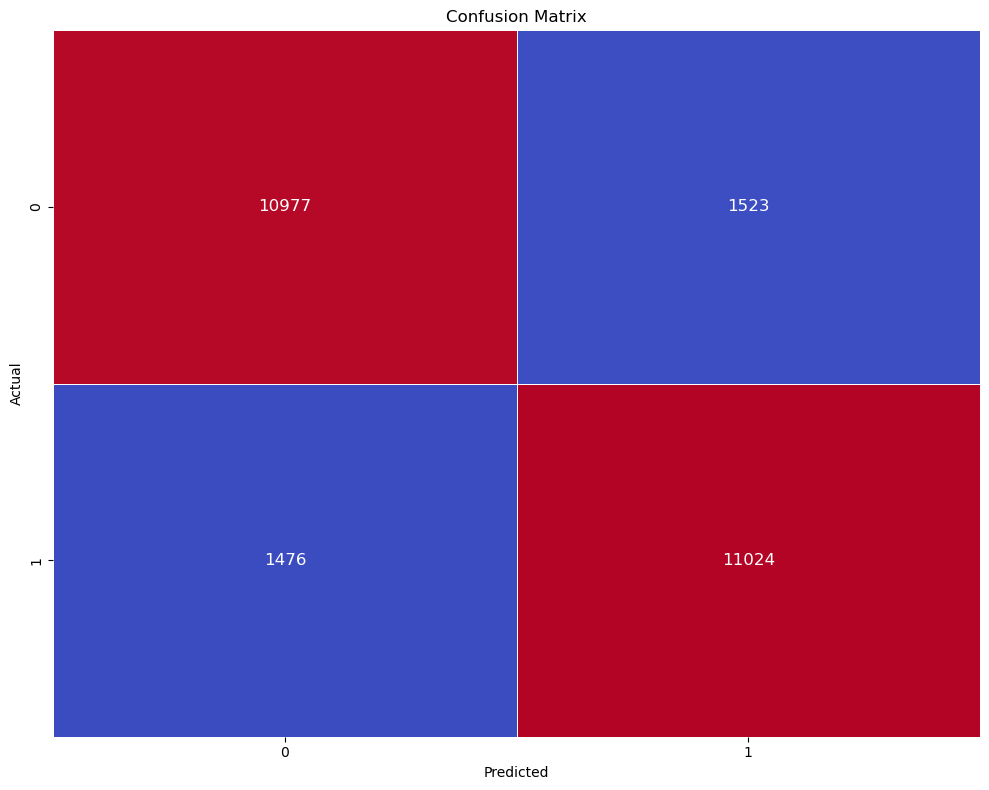

In [19]:
svm_stats = classification_report(y_test, svm_y_pred, output_dict = True)
nb_stats = classification_report(y_test, nb_y_pred, output_dict = True)
lr_stats = classification_report(y_test, lr_y_pred, output_dict = True)
cnn_stats = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict = True)

models = ['Support Vector', 'Naive Bayes', 'Logistic Regression', 'Convo Neural Network']
precision = [round(svm_stats['weighted avg']['precision'],4), round(nb_stats['weighted avg']['precision'],4), round(lr_stats['weighted avg']['precision'],4), round(cnn_stats['weighted avg']['precision'],4)]
recall = [round(svm_stats['weighted avg']['recall'],4), round(nb_stats['weighted avg']['recall'],4), round(lr_stats['weighted avg']['recall'],4), round(cnn_stats['weighted avg']['recall'],4)]
f1_score = [round(svm_stats['weighted avg']['f1-score'],4), round(nb_stats['weighted avg']['f1-score'],4), round(lr_stats['weighted avg']['f1-score'],4), round(cnn_stats['weighted avg']['f1-score'],4)]
accuracy = [round(svm_stats['accuracy'], 4), round(nb_stats['accuracy'], 4), round(lr_stats['accuracy'], 4), round(cnn_stats['accuracy'], 4)]
times = [svm_time, nb_time, lr_time, cnn_time]
results_df = pd.DataFrame({'Model': models, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Accuracy': accuracy, 'Time': times})

display(results_df)

print("Logistic Regression Confusion Matrix:")
conf_mat = confusion_matrix(y_test, lr_y_pred)
# print(conf_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=False, cmap='coolwarm', cbar=False, linewidths=.5)

# Add annotations manually with white text since seaborn hates me
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j + 0.5, i + 0.5, conf_mat[i, j], 
                 color='white', ha='center', va='center', fontsize=12)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Finally, I applied the unsupervised data to the Logistic Regression model for classification.

In [22]:
# unsupervised data prep
X_unsupervised = vectorized.transform(unsupervised_data['text'])

# Predict on unsupervised data
unsupervised_predictions = lr.predict(X_unsupervised)

# Add predictions to the unsupervised_data DataFrame
unsupervised_data['predictions'] = unsupervised_predictions

# Export the DataFrame to a CSV file
unsupervised_data[['text', 'predictions']].to_csv('unsupervised_predictions.csv', index=False)

print("Unsupervised predictions exported to 'unsupervised_predictions.csv'")
display(unsupervised_data.head(5))

Unsupervised predictions exported to 'unsupervised_predictions.csv'


,text,label,predictions
0,This is just a precious little diamond. The pl...,-1,1
1,When I say this is my favourite film of all ti...,-1,1
2,I saw this movie because I am a huge fan of th...,-1,1
3,Being that the only foreign films I usually li...,-1,0
4,After seeing Point of No Return (a great movie...,-1,0


In [23]:
print(unsupervised_data['predictions'].value_counts())

predictions
1    25052
0    24948
Name: count, dtype: int64


There are a predicted 25052 positive reviews and 24948 predicted negative reviews. That said, the Logistic Regression model shows only 88% accuracy, so I used my [confusion matrix scaler](https://sentimental-post.shinyapps.io/ConfusionMatrixScaler/), a tool I built in R shiny, to compensate for classification inaccuracies. I plugged in the training/testing confusion matrix numbers, then plug in the positive and negative predictions and the scaler estimates how many are true positives and negatives, and how many false positives and negatives we can expect, based on the training patterns. Here is the scaled matrix:  
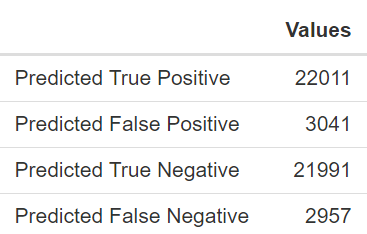

While this scaler can't tell us which review sentiments it thinks are misclassified, the scalar can give us a more realistic estimation of how many reviews are actually positive and negative, based on how training went.

#### Conclusion
As seen in the dataframe visualization, Logistic Regression performs the best when it comes to all the basic metrics, Precision, Recall, F1-Score, and Accuracy. The only thing LR didn't perform the best on was runtime, but given that it was still under 1 second, I think it makes it worth the wait. I believe using the confusion matrix scaler on top of the prediction helps manage expectations more than helps refine the model since we know it isn't a perfect classification. I recommend using the Logistic Regression model for classifying the 50k unclassified data points, which I have done just above and have attached in the zip file. I chose SVM, NB, and LR for their simplicity. I do not believe that every problem needs a Neural Network to solve, and even made that point extra clear by making a Neural Network that happened to not perform quite as well.

#### Next Steps
As mentioned in the intro, with more time I would like to try stacking the models to get better results and correct mistakes. On a scale of billions of data points, even a 1% false positive rate would be millions of false positives. Running them through different models may be able to reduce the load of misses without overfitting any one particular model.

With more time, I would also train classification trees and forests. I don't typically start with them because I believe the single trees are not as robust when it comes to training, and random forests obscure their methods, even if more robust. I'm more likely to use the forest in this assessment because of their ability to handle high dimensional data well. I also believe boosting or mixture models may be valuable in this analysis.

While I also believe in the power of Naive Bayes, I believe in its limitations too, primarily that it is naive to think that words are fully independent of one another. Using N-grams could help combat that, if there was time, or something like GloVe to assess word co-occurences.

#### Bibliography
[Header truncation and reset](https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver)  
[Vectorizers Documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
[GridSearch Documentation](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)  
[Support Vector Machines Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)  
[Multinomial Naive Bayes Documentation](https://scikit-learn.org/0.24/modules/generated/sklearn.naive_bayes.MultinomialNB.html)  
[Logistic Regression Documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)  
[Keras Tuner Documentation](https://keras.io/guides/keras_tuner/getting_started/)  